In [1]:
import os
import cv2
import matlab.engine
import scipy.io
import scipy.misc
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Stage 1 Feature extraction

In [2]:
PARAM_CLASSIFIERS_PATH = './classifiers/multiclass_classifiers/'
PARAM_STACKING_CLASSIFIERS_PATH = './classifiers/multiclass_stacking_classifier.bin'
PARAM_METHOD = 'multiclass_classifier'

In [3]:
# PARAM_CLASSIFIERS_PATH = './classifiers/separated_classifiers/'
# PARAM_STACKING_CLASSIFIERS_PATH = './classifiers/separated_stacking_classifier.bin'
# PARAM_METHOD = 'separated_classifiers'

In [4]:
#Read image and prepere file for matlab script
target = './images/motion0076.jpg'
im_name = target.split('/')[-1].split('.')[0]
image = scipy.misc.imread(target)
image_double = image/255.0
scipy.io.savemat('./feature_extraction/'+im_name+'.mat',{'im':image_double})

In [5]:
# Matlab eng start
# http://www.mathworks.com/help/matlab/matlab-engine-for-python.html
eng = matlab.engine.start_matlab()
eng.addpath('feature_extraction/feature')
eng.addpath('feature_extraction',nargout=0)

In [6]:
# Extract features by Matlab script (data is transported through *.mat files)
features = dict()
for patch_size in [11,15,21]:
    print('Scale '+str(patch_size)+' features extraction')
    eng.extract_features(im_name,patch_size,nargout=0)
    features[patch_size] = scipy.io.loadmat('./features.mat')
    del features[patch_size]['__version__']
    del features[patch_size]['__header__']
    del features[patch_size]['__globals__']
os.remove('./features.mat')
os.remove('./feature_extraction/'+im_name+'.mat')
print('Done')

Scale 11 features extraction
Scale 15 features extraction
Scale 21 features extraction
Done


In [7]:
# Matlab eng stop
eng.quit()

# Stage 2 Layer 1 prediction

In [8]:
def im2col(image,patch_size):
    patches = extract_patches_2d(image,patch_size)
    return list(map(lambda x: x.reshape(1,patch_size[0]*patch_size[1])[0],patches))

In [9]:
def predict_bcs(feature_data,patch_size):
    print('Load classifier for '+str(patch_size)+' pathsize prediction')
    classifier = xgb.XGBClassifier()
    booster = xgb.Booster()
    booster.load_model(classifiers_path[patch_size])
    classifier._Booster = booster
    
    print('Make prediction for '+str(patch_size)+' pathsize')
    predict = classifier.predict_proba(feature_data)
    predict = {'blur': predict[0][:int(predict.shape[1]/2)].reshape(feature_size),
               'clear': predict[1][:int(predict.shape[1]/2)].reshape(feature_size),
               'solid': predict[2][:int(predict.shape[1]/2)].reshape(feature_size),
    }
    del classifier
    del booster
    return predict

In [10]:
def predict_bc_s(feature_data,patch_size):
    print('Load classifier for '+str(patch_size)+' pathsize prediction')
    classifier = xgb.XGBClassifier()
    booster = xgb.Booster()
    booster.load_model(classifiers_path[patch_size])
    classifier._Booster = booster
    
    classifier_solid = xgb.XGBClassifier()
    booster_solid = xgb.Booster()
    booster_solid.load_model(classifiers_path[patch_size])
    classifier_solid._Booster = booster_solid
    
    print('Make prediction for '+str(patch_size)+' pathsize')
    predict = classifier.predict_proba(feature_data)
    predict_solid = classifier_solid.predict_proba(feature_data)
    predict = {'clear': predict[:,0].reshape(feature_size),
               'blur': predict[:,1].reshape(feature_size),
               'solid': predict_solid[:,1].reshape(feature_size),
    }
    
    del classifier
    del booster
    del classifier_solid
    del booster_solid
    return predict

In [11]:
if PARAM_METHOD == 'multiclass_classifier':
    classifiers_path = {11: PARAM_CLASSIFIERS_PATH + 'classifier11.bin',
                        15: PARAM_CLASSIFIERS_PATH + 'classifier15.bin',
                        21: PARAM_CLASSIFIERS_PATH + 'classifier21.bin'
    }
    predict_first_layer = predict_bcs
    SECOND_LAYER_PATHSIZE = 5
if PARAM_METHOD == 'separated_classifiers':
    classifiers_path = {11: PARAM_CLASSIFIERS_PATH + 'classifier11.bin',
                        15: PARAM_CLASSIFIERS_PATH + 'classifier15.bin',
                        21: PARAM_CLASSIFIERS_PATH + 'classifier21.bin'
    }
    classifiers_path_solid = {11: PARAM_CLASSIFIERS_PATH + 'classifier11_solid.bin',
                              15: PARAM_CLASSIFIERS_PATH + 'classifier15_solid.bin',
                              21: PARAM_CLASSIFIERS_PATH + 'classifier21_solid.bin'
    }
    predict_first_layer = predict_bc_s
    SECOND_LAYER_PATHSIZE = 5

In [12]:
feature_list = ['GHS','LK','LLF1','LLF2','LPSS','LSD']

In [13]:
# Make predictions for different pathsizes
predictions = dict()
predictions_solid = dict()
layer_results = dict()
for patch_size in [11,15,21]:
    print('Prepare data for '+str(patch_size)+' pathsize prediction')
    offset = int((21-int(patch_size))/2)
    feature_size = (features[patch_size]['LSD'].shape[0]-offset*2),(features[patch_size]['LSD'].shape[1]-offset*2)
    feature_length = feature_size[0]*feature_size[1]
    feature_data = []
    for feature_name in feature_list:
        if offset != 0:
            feature_data.append(features[patch_size][feature_name][offset:-offset,offset:-offset].reshape(1,feature_length)[0])
        else:
            feature_data.append(features[patch_size][feature_name].reshape(1,feature_length)[0])
    feature_data = np.array(feature_data).transpose()
    predictions[patch_size] = predict_first_layer(feature_data,patch_size)
    layer_results[patch_size] = predictions[patch_size]['blur']
    # Different classifiers requires different intput format
    if PARAM_METHOD == 'multiclass_classifier':
        # Format: blur11,clear11,solid11,blur15,clear15,solid15,blur21,clear21,solid21,
        for class_name in predictions[patch_size].keys():
            #Get features from patch 5*5
            predictions[patch_size][class_name] = im2col(predictions[patch_size][class_name],(SECOND_LAYER_PATHSIZE,SECOND_LAYER_PATHSIZE))
        predictions[patch_size] = np.hstack((predictions[patch_size]['blur'],predictions[patch_size]['clear'],predictions[patch_size]['solid']))
    if PARAM_METHOD == 'separated_classifiers':
        # Format: blur11,clear11,blur15,clear15,blur21,clear21,solid11,solid15,solid21,
        for class_name in predictions[patch_size].keys():
            #Get features from patch 5*5
            predictions[patch_size][class_name] = im2col(predictions[patch_size][class_name],(SECOND_LAYER_PATHSIZE,SECOND_LAYER_PATHSIZE))
        predictions_solid[patch_size] = predictions[patch_size]['solid']
        predictions[patch_size] = np.hstack((predictions[patch_size]['blur'],predictions[patch_size]['clear']))
# Different classifiers requires different intput format
if PARAM_METHOD == 'multiclass_classifier':
    # Format: blur11,clear11,solid11,blur15,clear15,solid15,blur21,clear21,solid21,
    prediction_layer1 = np.hstack((predictions[11],predictions[15],predictions[21]))
if PARAM_METHOD == 'separated_classifiers':
    # Format: blur11,clear11,blur15,clear15,blur21,clear21,solid11,solid15,solid21,
    prediction = np.hstack((predictions[11],predictions[15],predictions[21]))
    prediction_solid = np.hstack((predictions_solid[11],predictions_solid[15],predictions_solid[21]))
    prediction_layer1 = np.hstack((prediction,prediction_solid))
output_size = feature_size
print('Done')

Prepare data for 11 pathsize prediction
Load classifier for 11 pathsize prediction
Make prediction for 11 pathsize
Prepare data for 15 pathsize prediction
Load classifier for 15 pathsize prediction
Make prediction for 15 pathsize
Prepare data for 21 pathsize prediction
Load classifier for 21 pathsize prediction
Make prediction for 21 pathsize
Done


(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

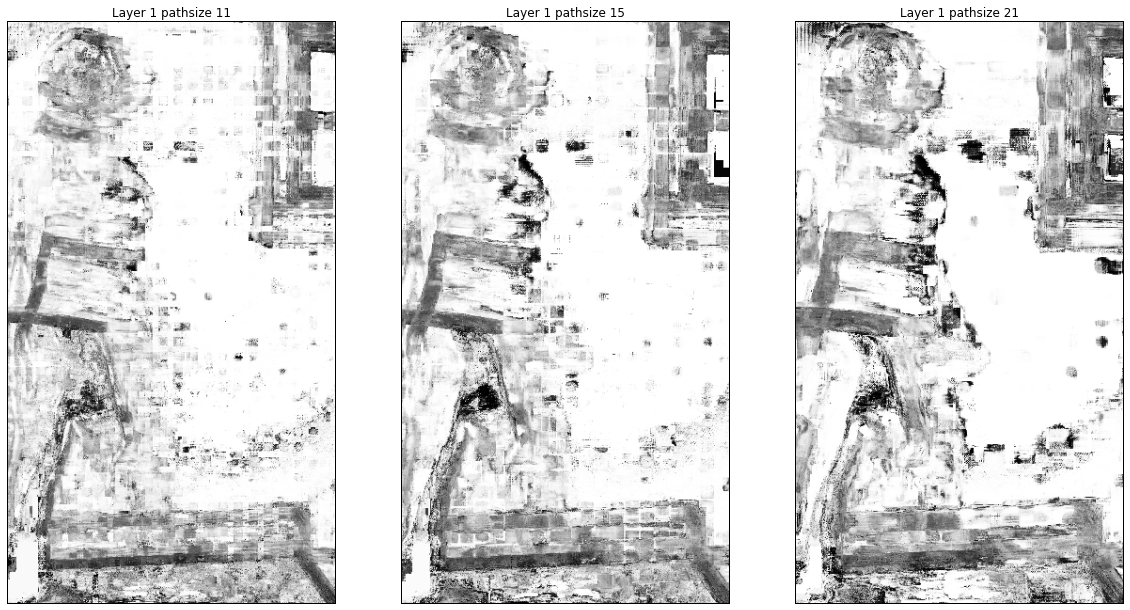

In [14]:
plt.figure(0,figsize=(20,12))
plt.subplot(1,3,1),plt.imshow(layer_results[11],cmap='gray'),plt.title('Layer 1 pathsize 11')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(layer_results[15],cmap='gray'),plt.title('Layer 1 pathsize 15')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(layer_results[21],cmap='gray'),plt.title('Layer 1 pathsize 21')
plt.xticks([]), plt.yticks([])

# Stage 3 Layer 2 prediction

In [15]:
stacking_booster = xgb.Booster()
stacking_booster.load_model(PARAM_STACKING_CLASSIFIERS_PATH)
stacking_classifier = xgb.XGBClassifier()
stacking_classifier._Booster = stacking_booster

In [16]:
prediction_layer2 = stacking_classifier.predict_proba(prediction_layer1)[:,1]
prediction_layer2 = prediction_layer2.reshape((output_size[0]-4,output_size[1]-4))

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

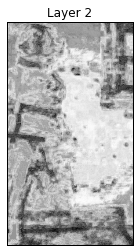

In [17]:
plt.imshow(prediction_layer2,cmap='gray')
plt.title('Layer 2')
plt.xticks([]), plt.yticks([])

# Stage 4 Solid color detection (possible mistakes areas)

In [18]:
FIRST_KERNEL_SIZE = 11
SECOND_KERNEL_SIZE = 5
N_COLOURS = 8
THRESHOLD = 0.0001

In [19]:
image = image[12:-12,12:-12,:]

In [20]:
def get_kernel(size):
    return np.ones((size,size),np.float32)/(size**2)

In [21]:
def reduce_color_count(image,n_colours):
    im_heigth = image.shape[0]
    im_width = image.shape[1]
    KM = KMeans(n_clusters=n_colours,init='k-means++')
    image2 = KM.fit_predict(image.reshape((im_heigth*im_width,image.shape[2])))
    image2 = np.array(list(map(lambda x: KM.cluster_centers_[x],image2)))
    image2 = image2.reshape((im_heigth,im_width,3))
    return 255 - image2.astype(int)

In [22]:
first_kernel = get_kernel(FIRST_KERNEL_SIZE)
second_kernel = get_kernel(SECOND_KERNEL_SIZE)
clustered_image = reduce_color_count(image,N_COLOURS)    
blurred_clustered_image = cv2.filter2D(clustered_image,-1,first_kernel)
clustered_images_difference = (np.sum((np.abs(clustered_image - blurred_clustered_image))/3.0,axis=2)).astype(float)
#smoothing
solid_color_areas  = cv2.filter2D(clustered_images_difference,-1,second_kernel)
#normalisation
solid_color_areas = (solid_color_areas - np.min(solid_color_areas))/np.max(solid_color_areas)
#edges restoration
solid_color_areas = 1-np.arctan(solid_color_areas/THRESHOLD)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

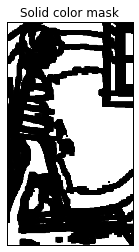

In [23]:
plt.imshow(solid_color_areas,cmap='gray')
plt.title('Solid color mask')
plt.xticks([]), plt.yticks([])

# Stage 5 Mark solid color areas

In [24]:
COLOR_SOLID = (90, 0, 157)
COLOR_BLUR = (1,1,1)
COLOR_CLEAR = (0,0,0)
SMOOTH_KERNEL_SIZE = 8
if PARAM_METHOD == 'multiclass_classifier':
    THRESHOLD = 0.7
if PARAM_METHOD == 'separated_classifiers':
    THRESHOLD = 0.85


In [25]:
def choose_area_type(blur_score,solid_score):
    if solid_score > 0.5:
        return COLOR_SOLID
    if blur_score> THRESHOLD:
        return COLOR_BLUR
    else:
        return COLOR_CLEAR
    

def mark_solid_colour_areas(blur_prediction,solid_prediction):
    return np.array(list(map(choose_area_type,blur_prediction,solid_prediction)))

result = np.array(list(map(mark_solid_colour_areas,prediction_layer2,solid_color_areas)))

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

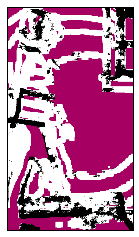

In [26]:
plt.imshow(result)
plt.xticks([]), plt.yticks([])

In [27]:
result_smoothed = cv2.filter2D(result,-1,get_kernel(SMOOTH_KERNEL_SIZE))

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

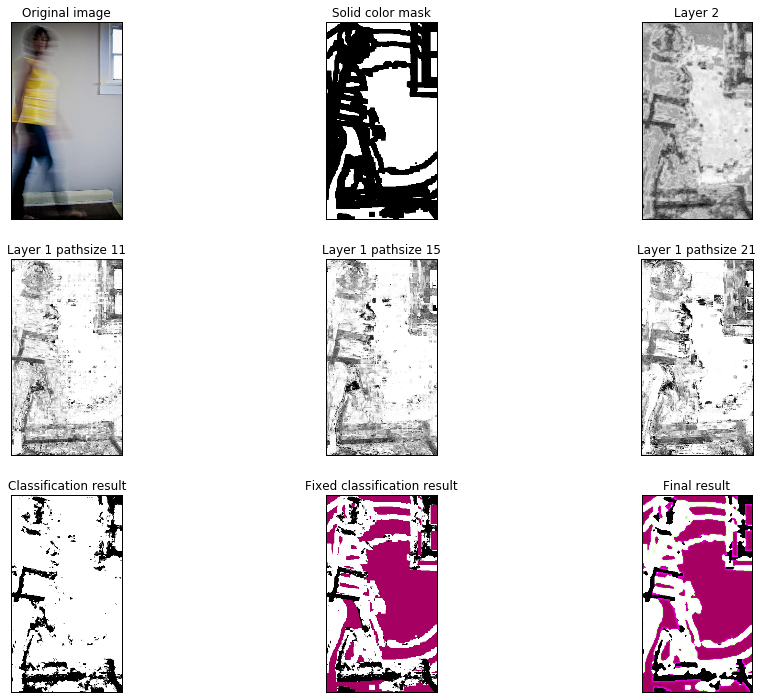

In [28]:
plt.figure(0,figsize=(16,12))
plt.subplot(3,3,1),plt.imshow(image,cmap='gray'),plt.title('Original image')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,2),plt.imshow(solid_color_areas,cmap='gray'),plt.title('Solid color mask')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,3),plt.imshow(prediction_layer2,cmap='gray'),plt.title('Layer 2')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,4),plt.imshow(layer_results[11],cmap='gray'),plt.title('Layer 1 pathsize 11')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,5),plt.imshow(layer_results[15],cmap='gray'),plt.title('Layer 1 pathsize 15')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,6),plt.imshow(layer_results[21],cmap='gray'),plt.title('Layer 1 pathsize 21')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,7),plt.imshow(prediction_layer2>THRESHOLD,cmap='gray'),plt.title('Classification result')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,8),plt.imshow(result),plt.title('Fixed classification result')
plt.xticks([]), plt.yticks([])
plt.subplot(3,3,9),plt.imshow(result_smoothed),plt.title('Final result')
plt.xticks([]), plt.yticks([])